# Imports

In [1]:
from __future__ import annotations
from typing import Tuple, List, Dict, Optional, Any

import os
import json
from pathlib import Path

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset, DownloadMode

import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import tqdm

from helper_utils.enum_keys import (
    FPKey,
    ModelKey,
    QuantStyle,
    MiscPrompts,
    Contexts,
    Texts
)

from PTQ.apply_ptq import applyPTQ
from PTQ.olmo_act_fns import patch_olmo_mlp
import helper_utils.utils as utils

from mech_interp_utils.utils_main.src.transformer_utils import (
    logit_lens,
    activation_lens,
    dictionary_learning,
    chatbot_analysis
)

import warnings
warnings.filterwarnings('ignore')

c:\Users\ampir\anaconda3\envs\MechInterp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
import os
import json
import pandas as pd
from pathlib import Path

def load_metrics_from_directory(directory_path):
    """
    Load metrics from a directory of JSON files (list of dicts per file).
    """
    all_metrics = []
    for filename in os.listdir(directory_path):
        if not filename.endswith(".json"):
            continue
        filepath = os.path.join(directory_path, filename)
        with open(filepath, 'r') as f:
            try:
                data = json.load(f)
                if isinstance(data, list) and all(isinstance(item, dict) for item in data):
                    for item in data:
                        item['file_name'] = filename
                    all_metrics.extend(data)
                else:
                    print(f"[!] Unexpected structure in {filename}")
            except Exception as e:
                print(f"[!] Failed to load {filename}: {e}")
    print(f"Loaded {len(all_metrics)} total entries from {directory_path}")
    return all_metrics


def load_all_model_metrics(source_map):
    """
    Load metrics from either individual JSON files or directories,
    tagging each record with a model_id for later analysis.

    Parameters:
        source_map (dict): Mapping from model name to path (file or directory)

    Returns:
        pd.DataFrame: All metrics combined and annotated with model identity
    """
    records = []

    for model_name, path in source_map.items():
        path_obj = Path(path)
        if path_obj.is_file():
            try:
                with open(path, "r") as f:
                    data = json.load(f)
                for entry in data:
                    entry['model_id'] = model_name
                    entry['file_name'] = path_obj.name
                    records.append(entry)
            except Exception as e:
                print(f"[!] Failed to load {path}: {e}")
        elif path_obj.is_dir():
            data = load_metrics_from_directory(path)
            for entry in data:
                entry['model_id'] = model_name
            records.extend(data)
        else:
            print(f"[!] Invalid path: {path}")

    print(f"Total entries combined: {len(records)}")
    return pd.DataFrame(records)


In [ ]:
model_sources = {
    'OLMo-1B-hf': 'logs/gsm8k_answers/olmo.1b.fp32.json',
    'OLMo-1B-8bit': 'logs/gsm8k_answers/olmo.1b-bnb8bit.fp32.json',
    'OLMo-1B-4bit': 'logs/gsm8k_answers/olmo.1b-bnb4bit.fp32.json',
    'OLMo-1B-1.58bit': 'logs/gsm8k_answers/olmo.1b-ptsq.fp32.json',
    'DeepHermes-LLaMA-3B': 'logs/gsm8k_answers/dh.3b-llama.fp32.json',
    'DeepHermes-3B-8bit': 'logs/gsm8k_answers/dh.3b-bnb8bit.fp32.json',
    'DeepHermes-3B-4bit': 'logs/gsm8k_answers/dh.3b-bnb4bit.fp32.json',
    'DeepHermes-3B-1.58bit': 'logs/gsm8k_answers/dh.3b-ptsq.fp32.json',
    'LLaMA-Instruct-8B': 'logs/gsm8k_answers/llama.8b-instruct.fp32.json',
    'LLaMA-Instruct-8B-8bit': 'logs/gsm8k_answers/llama.8b-bnb8bit.fp32.json',
    'LLaMA-Instruct-8B-4bit': 'logs/gsm8k_answers/llama.8b-bnb4bit.fp32.json',
    'HF1BitLLM': 'logs/gsm8k_answers/llama.8b-1.58.fp32.json'
}

df_all = load_all_model_metrics(model_sources)


In [ ]:
model_sources = {
    'OLMo-1B-hf': 'logs/gsm8k_questions/olmo.1b.fp32.json',
    'OLMo-1B-8bit': 'logs/gsm8k_questions/olmo.1b-bnb8bit.fp32.json',
    'OLMo-1B-4bit': 'logs/gsm8k_questions/olmo.1b-bnb4bit.fp32.json',
    'OLMo-1B-1.58bit': 'logs/gsm8k_questions/olmo.1b-ptsq.fp32.json',
    'DeepHermes-LLaMA-3B': 'logs/gsm8k_questions/dh.3b-llama.fp32.json',
    'DeepHermes-3B-8bit': 'logs/gsm8k_questions/dh.3b-bnb8bit.fp32.json',
    'DeepHermes-3B-4bit': 'logs/gsm8k_questions/dh.3b-bnb4bit.fp32.json',
    'DeepHermes-3B-1.58bit': 'logs/gsm8k_questions/dh.3b-ptsq.fp32.json',
    'LLaMA-Instruct-8B': 'logs/gsm8k_questions/llama.8b-instruct.fp32.json',
    'LLaMA-Instruct-8B-8bit': 'logs/gsm8k_questions/llama.8b-bnb8bit.fp32.json',
    'LLaMA-Instruct-8B-4bit': 'logs/gsm8k_questions/llama.8b-bnb4bit.fp32.json',
    'HF1BitLLM': 'logs/gsm8k_questions/llama.8b-1.58.fp32.json'
}

df_all = load_all_model_metrics(model_sources)

In [ ]:
model_sources = {
    'OLMo-1B-hf': 'logs/nq_queries/olmo.1b.fp32.json',
    'OLMo-1B-8bit': 'logs/nq_queries/olmo.1b-bnb8bit.fp32.json',
    'OLMo-1B-4bit': 'logs/nq_queries/olmo.1b-bnb4bit.fp32.json',
    'OLMo-1B-1.58bit': 'logs/nq_queries/olmo.1b-ptsq.fp32.json',
    'DeepHermes-LLaMA-3B': 'logs/nq_queries/dh.3b-llama.fp32.json',
    'DeepHermes-3B-8bit': 'logs/nq_queries/dh.3b-bnb8bit.fp32.json',
    'DeepHermes-3B-4bit': 'logs/nq_queries/dh.3b-bnb4bit.fp32.json',
    'DeepHermes-3B-1.58bit': 'logs/nq_queries/dh.3b-ptsq.fp32.json',
    'LLaMA-Instruct-8B': 'logs/nq_queries/llama.8b-instruct.fp32.json',
    'LLaMA-Instruct-8B-8bit': 'logs/nq_queries/llama.8b-bnb8bit.fp32.json',
    'LLaMA-Instruct-8B-4bit': 'logs/nq_queries/llama.8b-bnb4bit.fp32.json',
    'HF1BitLLM': 'logs/nq_queries/llama.8b-1.58.fp32.json'
}

df_all = load_all_model_metrics(model_sources)

In [11]:
model_sources = {
    'OLMo-1B-hf': 'logs/nq_answers/olmo.1b.fp32.json',
    'OLMo-1B-8bit': 'logs/nq_answers/olmo.1b-bnb8bit.fp32.json',
    'OLMo-1B-4bit': 'logs/nq_answers/olmo.1b-bnb4bit.fp32.json',
    'OLMo-1B-1.58bit': 'logs/nq_answers/olmo.1b-ptsq.fp32.json',
    'DeepHermes-LLaMA-3B': 'logs/nq_answers/dh.3b-llama.fp32.json',
    'DeepHermes-3B-8bit': 'logs/nq_answers/dh.3b-bnb8bit.fp32.json',
    'DeepHermes-3B-4bit': 'logs/nq_answers/dh.3b-bnb4bit.fp32.json',
    'DeepHermes-3B-1.58bit': 'logs/nq_answers/dh.3b-ptsq.fp32.json',
    'LLaMA-Instruct-8B': 'logs/nq_answers/llama.8b-instruct.fp32.json',
    'LLaMA-Instruct-8B-8bit': 'logs/nq_answers/llama.8b-bnb8bit.fp32.json',
    'LLaMA-Instruct-8B-4bit': 'logs/nq_answers/llama.8b-bnb4bit.fp32.json',
    'HF1BitLLM': 'logs/nq_answers/llama.8b-1.58.fp32.json'
}

df_all = load_all_model_metrics(model_sources)

Total entries combined: 240


In [12]:
df_all.head()

,prompt,decoded_prompt_str,tokens,prompt_type,target_ids,target_tokens,layer_names,correct_1,correct_topk,correct_1_std,...,correct_topk_by_position,entropy,normalized_entropy,logit_mean,prob_mean,stability_top1,stability_topk,layer_kl_divergences,model_id,file_name
0,"[[17389, 9456, 15794, 9585, 25380, 3407, 4240,...",Richmond Football Club Richmond began 2017 wit...,"[Rich, mond, ĠFootball, ĠClub, ĠRichmond, Ġbeg...",text,"[9456, 15794, 9585, 25380, 3407, 4240, 342, 60...","[mond, ĠFootball, ĠClub, ĠRichmond, Ġbegan, Ġ2...","[model.layers.0, model.layers.1, model.layers....","[1.0, 1.0, 0.8, 0.6666666666666666, 0.53333333...","[1.0, 1.0, 0.9333333333333333, 0.6666666666666...","[0.0, 0.0, 0.4, 0.47140452079103173, 0.4988876...",...,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,...","[10.756144523620605, 10.807570457458496, 10.81...","[[0.9778485298156738, 0.993316650390625, 0.983...","[5.030283451080322, 2.4894778728485107, 1.7052...","[0.007354279048740864, 0.0003936590801458806, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[[0.11137033998966217, 0.04020148515701294, 0....",OLMo-1B-hf,olmo.1b.fp32.json
1,"[[16082, 7493, 313, 4093, 254, 10, 2058, 253, ...","Jack Scott (singer) At the beginning of 1960, ...","[Jack, ĠScott, Ġ(, sing, er, ), ĠAt, Ġthe, Ġbe...",text,"[7493, 313, 4093, 254, 10, 2058, 253, 5068, 27...","[ĠScott, Ġ(, sing, er, ), ĠAt, Ġthe, Ġbeginnin...","[model.layers.0, model.layers.1, model.layers....","[1.0, 0.9333333333333333, 0.8, 0.6666666666666...","[1.0, 1.0, 0.8666666666666667, 0.6666666666666...","[0.0, 0.24944382578492943, 0.4, 0.471404520791...",...,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,...","[10.724294662475586, 10.8092622756958, 10.8132...","[[0.9967544674873352, 0.9980196952819824, 0.95...","[5.072450637817383, 2.083895206451416, 1.41339...","[0.011206414550542831, 0.00023871877056080848,...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[[0.028099993243813515, 0.03677203878760338, 0...",OLMo-1B-hf,olmo.1b.fp32.json
2,"[[56, 1062, 11841, 25818, 3275, 310, 670, 374,...",Wool Global wool production is about 2 million...,"[W, ool, ĠGlobal, Ġwool, Ġproduction, Ġis, Ġab...",text,"[1062, 11841, 25818, 3275, 310, 670, 374, 3041...","[ool, ĠGlobal, Ġwool, Ġproduction, Ġis, Ġabout...","[model.layers.0, model.layers.1, model.layers....","[1.0, 1.0, 0.8666666666666667, 0.6666666666666...","[1.0, 1.0, 1.0, 0.7333333333333333, 0.66666666...","[0.0, 0.0, 0.339934634239519, 0.47140452079103...",...,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,...","[10.71219539642334, 10.80852222442627, 10.8123...","[[0.9076886773109436, 0.9939619898796082, 0.99...","[5.187832355499268, 2.4061098098754883, 1.6752...","[0.012746719643473625, 0.0003259088553022593, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[[0.4904257357120514, 0.037792764604091644, 0....",OLMo-1B-hf,olmo.1b.fp32.json
3,"[[2422, 11304, 27, 380, 9859, 48688, 20829, 27...",Alaska: The Last Frontier Alaska: The Last Fro...,"[Al, aska, :, ĠThe, ĠLast, ĠFrontier, ĠAlaska,...",text,"[11304, 27, 380, 9859, 48688, 20829, 27, 380, ...","[aska, :, ĠThe, ĠLast, ĠFrontier, ĠAlaska, :, ...","[model.layers.0, model.layers.1, model.layers....","[1.0, 1.0, 0.9333333333333333, 0.6666666666666...","[1.0, 1.0, 1.0, 0.8, 0.6666666666666666, 0.533...","[0.0, 0.0, 0.24944382578492943, 0.471404520791...",...,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,...","[10.770737648010254, 10.80851936340332, 10.813...","[[0.9897329211235046, 0.9984946250915527, 0.99...","[5.026289463043213, 2.6048905849456787, 1.7857...","[0.006153601221740246, 0.0005233273259364069, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[[0.04795553907752037, 0.02789744734764099, 0....",OLMo-1B-hf,olmo.1b.fp32.json
4,"[[3074, 309, 29430, 313, 34, 6258, 281, 

In [13]:
print(df_all['model_id'].value_counts())
print(df_all.columns)


model_id
OLMo-1B-hf                20
OLMo-1B-8bit              20
OLMo-1B-4bit              20
OLMo-1B-1.58bit           20
DeepHermes-LLaMA-3B       20
DeepHermes-3B-8bit        20
DeepHermes-3B-4bit        20
DeepHermes-3B-1.58bit     20
LLaMA-Instruct-8B         20
LLaMA-Instruct-8B-8bit    20
LLaMA-Instruct-8B-4bit    20
HF1BitLLM                 20
Name: count, dtype: int64
Index(['prompt', 'decoded_prompt_str', 'tokens', 'prompt_type', 'target_ids',
       'target_tokens', 'layer_names', 'correct_1', 'correct_topk',
       'correct_1_std', 'correct_topk_std', 'correct_1_by_position',
       'correct_topk_by_position', 'entropy', 'normalized_entropy',
       'logit_mean', 'prob_mean', 'stability_top1', 'stability_topk',
       'layer_kl_divergences', 'model_id', 'file_name'],
      dtype='object')


In [14]:
def flatten_singleton_lists(df, columns):
    """
    Replace singleton lists (e.g., [0.5]) with scalar values in specified columns.
    """
    for col in columns:
        df[col] = df[col].apply(lambda x: x[0] if isinstance(x, list) and len(x) == 1 else x)
    return df


In [15]:
singleton_cols = ['entropy', 'normalized_entropy', 'logit_mean', 'prob_mean',
                  'stability_top1', 'stability_topk']  # Add others if needed

df_all = flatten_singleton_lists(df_all, singleton_cols)


In [16]:
singleton_cols = ['prompt', 'decoded_prompt_str', 'tokens', 'prompt_type', 'target_ids',
       'target_tokens', 'layer_names', 'correct_1', 'correct_topk',
       'correct_1_std', 'correct_topk_std', 'correct_1_by_position',
       'correct_topk_by_position', 'entropy', 'normalized_entropy',
       'logit_mean', 'prob_mean', 'stability_top1', 'stability_topk',
       'layer_kl_divergences', 'model_id', 'file_name']  # Add others if needed

df_all = flatten_singleton_lists(df_all, singleton_cols)

In [17]:
df_all['kl_layer_last'] = df_all['layer_kl_divergences'].apply(lambda x: x[-1] if isinstance(x, list) else np.nan)
df_all['kl_layer_mean'] = df_all['layer_kl_divergences'].apply(lambda x: np.mean(x) if isinstance(x, list) else np.nan)


In [18]:
df_all['logit_std'] = df_all['logit_mean'].apply(np.std)

## Language and Cosine

In [ ]:
from scipy.spatial.distance import cosine

def compute_cosine_similarity_per_position(probs1, probs2):
    return [1 - cosine(p1, p2) if not (np.all(p1 == 0) or np.all(p2 == 0)) else 0.0
            for p1, p2 in zip(probs1, probs2)]


In [ ]:
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 42  # ensure consistent results

#df_all['language'] = df_all['decoded_prompt_str'].apply(lambda x: detect(x) if isinstance(x, str) else 'unknown')
#df_all['language'] = df_all['tokens'].apply(lambda x: detect(x) if isinstance(x, str) else 'unknown')
df_all['language'] = df_all['target_tokens'].apply(lambda x: detect(x) if isinstance(x, str) else 'unknown')


In [ ]:
for w in df_all['language']:
    if w != 'en':
        print(w)

In [ ]:
df_all.columns

In [20]:
metrics_config = [
    #("prob_mean", "e) Mean Prob of TopK", "Mean Prob."),
    ("logit_mean", "a) Mean Logit Magnitude", "Mean Logit"),
    ("normalized_entropy", "b) Normalized Entropy per Layer", "Norm. Entropy"),
    ("layer_kl_divergences", "c) KL Divergence per Layer", "KL Divergence"),
    ("correct_1", "d) Correct TopK-1", "Correct"),
    ("correct_1_std", "e) Correct TopK-1 Std.", "Std."),
    ("stability_top1", "f) TopK-1 Stability", "Stability"),
    ("correct_topk", "g) Correct TopK-5", "Correct"),
    ("correct_topk_std", "h) Correct TopK-5 Std.", "Std."),
    ("stability_topk", "i) TopK-5 Stability", "Stability"),
]

#plot_model_diagnostics_variable_depth(df_all, metrics_config)


In [ ]:
# Extract final-layer KL for overview
df_all['kl_final_layer'] = df_all['layer_kl_divergences'].apply(lambda x: x[-1] if isinstance(x, list) else np.nan)


## With Font Controls

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set seaborn style
sns.set(style="whitegrid")

def flatten_layerwise_metric(row):
    """Flattens overly nested [[...]] or [[[...]]] metrics."""
    while isinstance(row, list) and len(row) == 1 and isinstance(row[0], list):
        row = row[0]
    return row

def average_nested_per_layer(data):
    """Convert list-of-lists (per layer) to averaged list per layer."""
    return [np.mean(layer) if isinstance(layer, list) and layer else np.nan for layer in data]

def plot_model_diagnostics_variable_depth(
    df,
    metrics_config,
    title="TopK-5 Quantized Model Diagnostic Landscape",
    max_layer_len=32,
    font_sizes=None
):
    # Default font sizes if none provided
    if font_sizes is None:
        font_sizes = {
            "title": 24,
            "subtitle": 18,
            "xlabel": 16,
            "ylabel": 16,
            "xtick": 14,
            "ytick": 14,
            "legend": 16
        }

    num_plots = len(metrics_config)
    num_rows = (num_plots + 2) // 3

    # Use Times New Roman and set figure size
    plt.rcParams['font.family'] = 'Times New Roman'
    fig, axs = plt.subplots(num_rows, 3, figsize=(22, 5 * num_rows), sharex=False)
    axs = axs.flatten()

    model_ids = df['model_id'].unique()
    model_colors = {
        model: color for model, color in zip(model_ids, sns.color_palette("tab20", len(model_ids)))
    }

    double_nested_metrics = {"layer_kl_divergences", "normalized_entropy"}

    for i, (metric_key, subplot_title, y_label) in enumerate(metrics_config):
        ax = axs[i]

        for model_id, group in df.groupby("model_id"):
            layerwise_aggregates = []

            for row in group[metric_key].dropna():
                row = flatten_layerwise_metric(row)

                if metric_key in double_nested_metrics:
                    if not isinstance(row, list) or not all(isinstance(r, list) for r in row):
                        continue
                    averaged = average_nested_per_layer(row)
                else:
                    try:
                        averaged = np.asarray(row, dtype=np.float32).flatten().tolist()
                    except Exception:
                        continue

                if not averaged or np.any(np.isnan(averaged)) or np.any(np.isinf(averaged)):
                    continue

                if len(averaged) > max_layer_len:
                    averaged = averaged[:max_layer_len]

                layerwise_aggregates.append(averaged)

            if not layerwise_aggregates:
                continue

            max_len = max(len(v) for v in layerwise_aggregates)
            per_layer_values = [[] for _ in range(max_len)]

            for v in layerwise_aggregates:
                for j, val in enumerate(v):
                    per_layer_values[j].append(val)

            means = np.array([np.mean(l) if l else np.nan for l in per_layer_values])
            stds = np.array([np.std(l) if l else np.nan for l in per_layer_values])
            x = np.arange(len(means))

            ax.plot(x, means, label=model_id, color=model_colors[model_id])
            ax.fill_between(x, means - stds, means + stds, color=model_colors[model_id], alpha=0.2)

            last_valid = np.where(~np.isnan(means))[0][-1]
            ax.plot(x[last_valid], means[last_valid], 'o', color=model_colors[model_id], markersize=8)

        ax.set_title(subplot_title, fontsize=font_sizes["subtitle"])
        ax.set_xlabel("Layer Index", fontsize=font_sizes["xlabel"])
        ax.set_ylabel(y_label, fontsize=font_sizes["ylabel"])
        ax.tick_params(axis='x', labelsize=font_sizes["xtick"])
        ax.tick_params(axis='y', labelsize=font_sizes["ytick"])
        ax.grid(True)

    # Remove unused axes
    for j in range(len(metrics_config), len(axs)):
        fig.delaxes(axs[j])

    # Shared legend and figure title
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=4, fontsize=font_sizes["legend"],
               frameon=False, bbox_to_anchor=(0.5, 1.05))
    #fig.suptitle(title, fontsize=font_sizes["title"])

    plt.tight_layout(rect=[0, 0, 1, 0.93])  # adjust to leave space for legend and title
    fig.savefig('nq_answers_lineplots.jpg', bbox_inches='tight', dpi=300)
    plt.show()


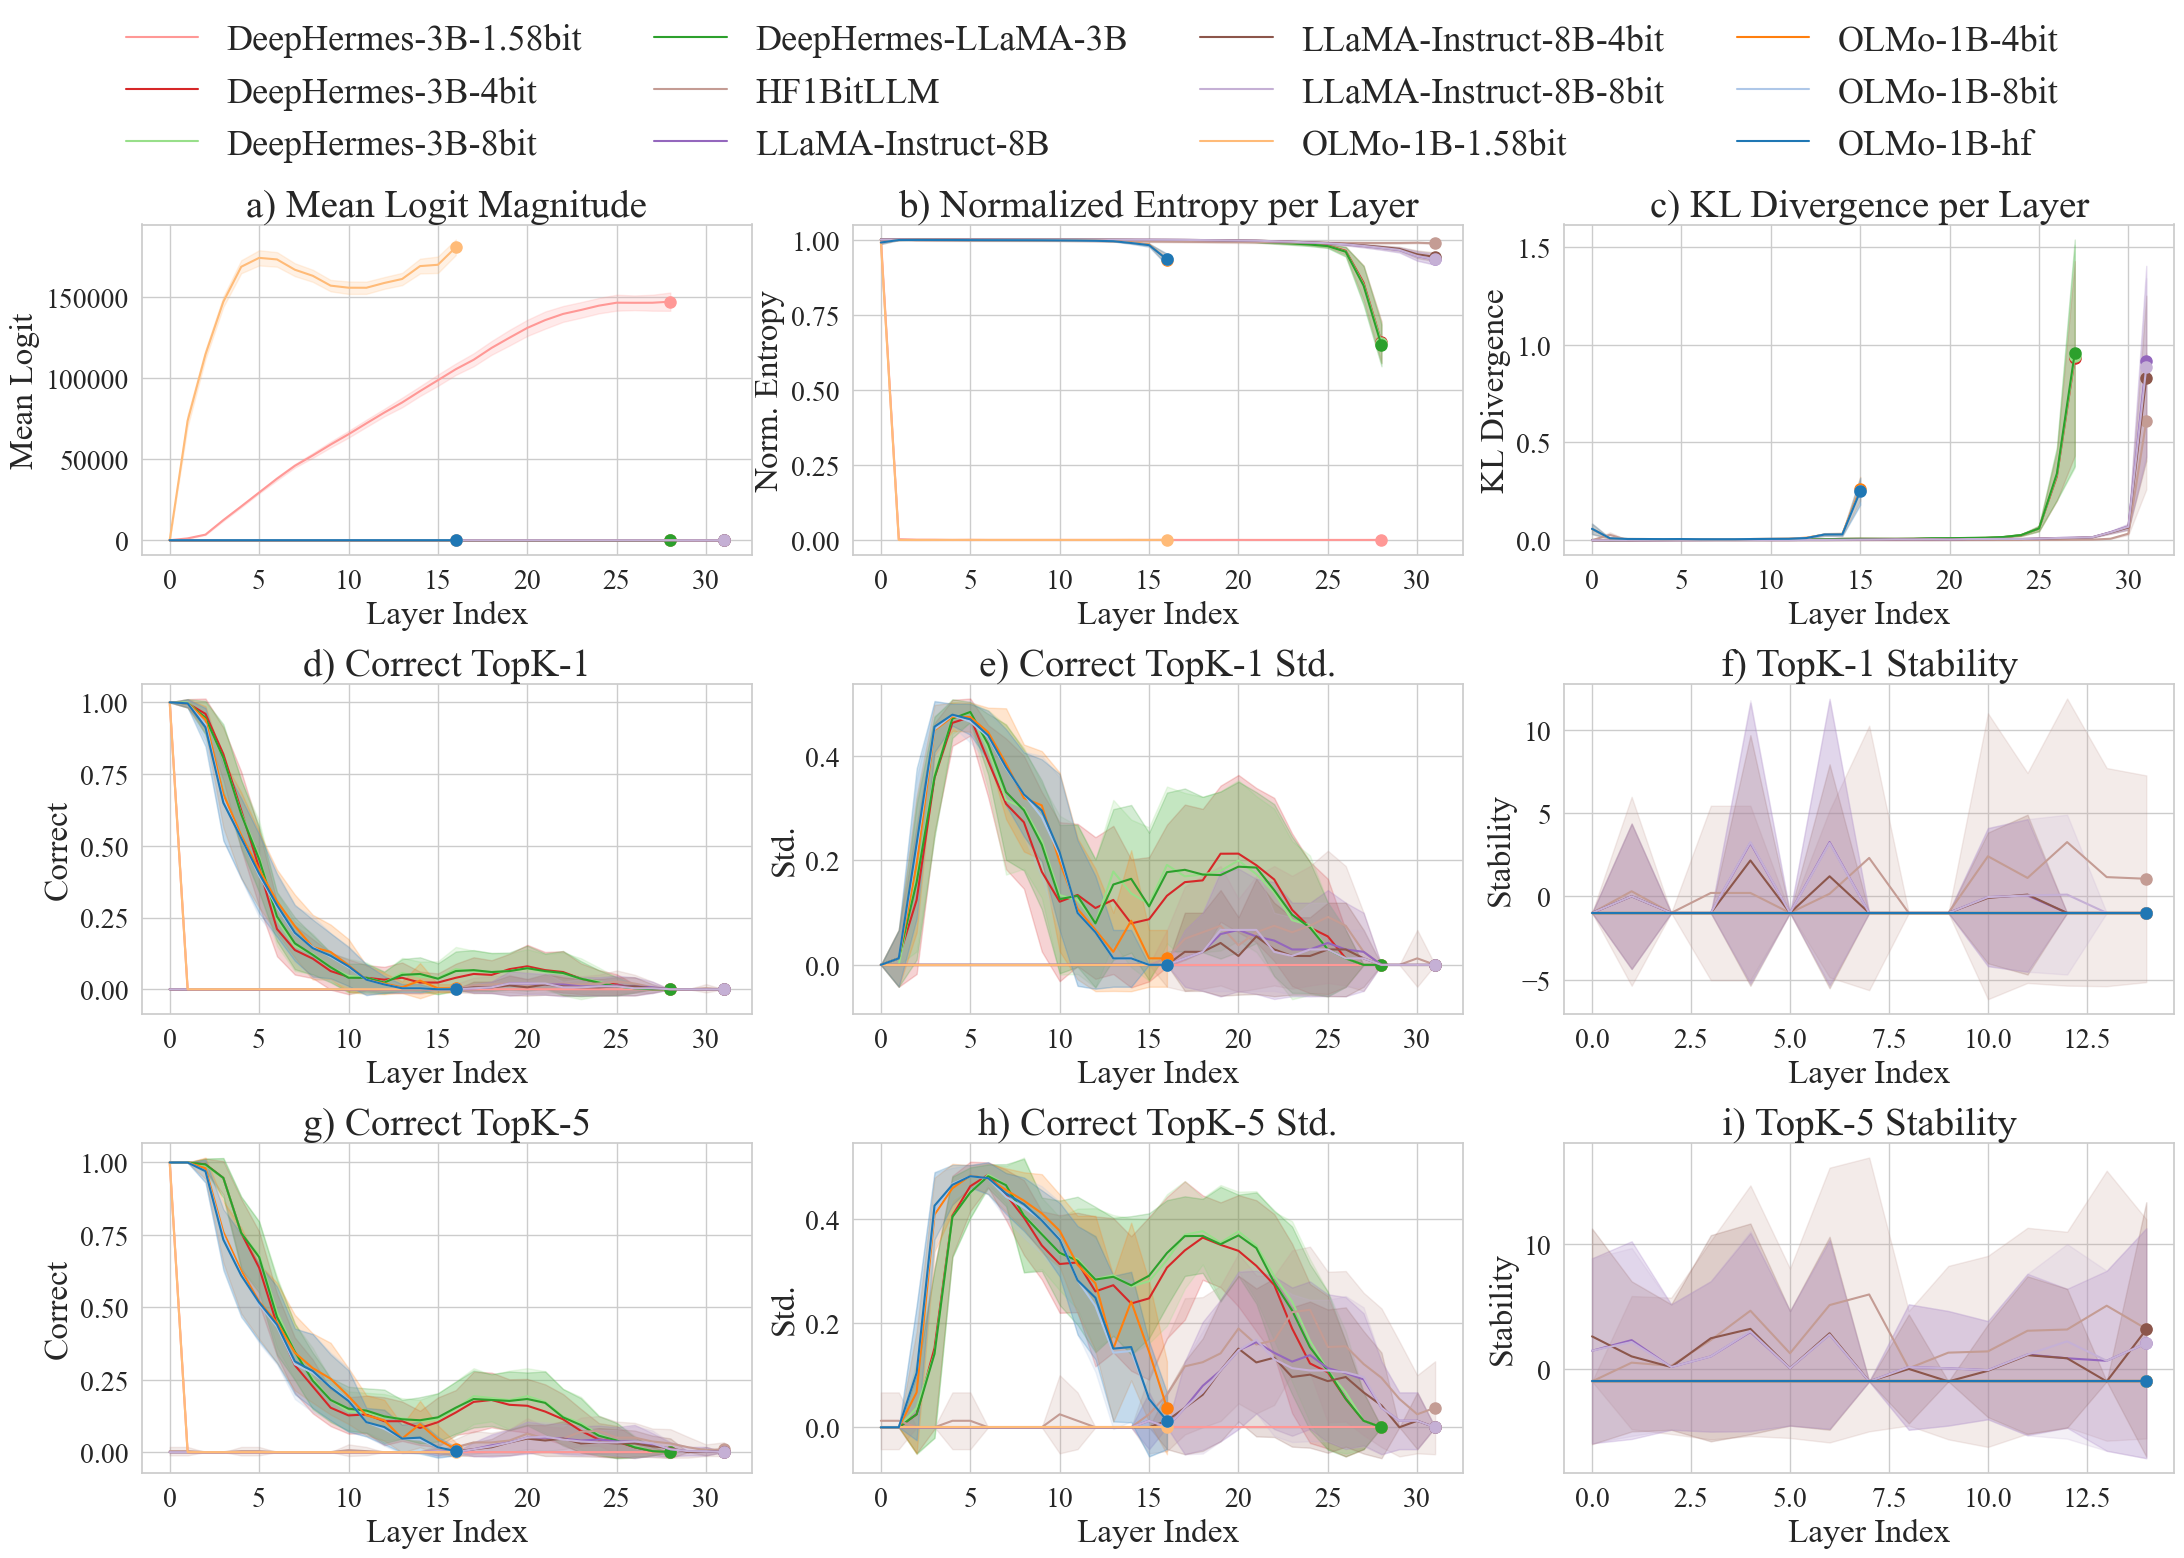

In [25]:
plot_model_diagnostics_variable_depth(
    df_all,
    metrics_config,
    font_sizes={
        "title": 36,
        "subtitle": 28,
        "xlabel": 24,
        "ylabel": 24,
        "xtick": 20,
        "ytick": 20,
        "legend": 26
    }
)


In [ ]:
import pandas as pd
from scipy.stats import pearsonr

def compute_layerwise_metric_correlations(df, metrics_to_compare, max_layer_len=32):
    import pandas as pd
    import numpy as np

    metric_data = {metric: [] for metric in metrics_to_compare}

    for metric in metrics_to_compare:
        for _, row in df.iterrows():
            data = row[metric]
            if data is None or (isinstance(data, float) and np.isnan(data)):
                continue

            data = flatten_layerwise_metric(data)

            if isinstance(data, list) and all(isinstance(d, list) for d in data):
                data = average_nested_per_layer(data)
            try:
                flattened = np.asarray(data, dtype=np.float32).flatten()
                if len(flattened) < max_layer_len:
                    padded = np.full((max_layer_len,), np.nan, dtype=np.float32)
                    padded[:len(flattened)] = flattened
                    flattened = padded
                elif len(flattened) > max_layer_len:
                    flattened = flattened[:max_layer_len]

            except Exception:
                continue

            if len(flattened) > max_layer_len:
                flattened = flattened[:max_layer_len]

            if not len(flattened) or np.any(np.isnan(flattened)) or np.any(np.isinf(flattened)):
                continue

            metric_data[metric].append(flattened)

    # Align all metrics by truncating/padding each run
    min_samples = min(len(v) for v in metric_data.values())
    for key in metric_data:
        metric_data[key] = metric_data[key][:min_samples]

    # Convert to matrix: shape = (num_samples, num_metrics, num_layers)
    all_metrics = []
    for key in metrics_to_compare:
        all_metrics.append(np.stack(metric_data[key]))  # shape: (samples, layers)
    all_metrics = np.stack(all_metrics, axis=1)  # shape: (samples, metrics, layers)

    # Compute correlation per-layer and average across layers
    correlations = np.full((len(metrics_to_compare), len(metrics_to_compare)), np.nan)
    for i in range(len(metrics_to_compare)):
        for j in range(len(metrics_to_compare)):
            values_i = all_metrics[:, i, :].flatten()
            values_j = all_metrics[:, j, :].flatten()
            if np.std(values_i) > 0 and np.std(values_j) > 0:
                correlations[i, j] = np.corrcoef(values_i, values_j)[0, 1]

    return pd.DataFrame(
        correlations,
        index=metrics_to_compare,
        columns=metrics_to_compare
    )



In [ ]:
corr_config = [
    #("prob_mean", "e) Mean Prob of TopK", "Mean Prob."),
    ("logit_mean", "a) Mean Logit Magnitude", "Mean Logit"),
    ("normalized_entropy", "b) Normalized Entropy per Layer", "Norm. Entropy"),
    ("layer_kl_divergences", "c) KL Divergence per Layer", "KL Divergence"),
    ("correct_1", "d) Correct TopK-1", "Correct"),
    ("correct_1_std", "e) Correct TopK-1 Std.", "Std."),
    ("correct_topk", "g) Correct TopK-5", "Correct"),
    ("correct_topk_std", "h) Correct TopK-5 Std.", "Std."),
]

In [ ]:
#sns.set(style="whitegrid")

def plot_correlation_heatmap(corr_matrix, title="Metric Correlation Across Layers"):
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True,
                cbar_kws={"shrink": 0.8}, linewidths=0.5, linecolor="gray")
    plt.title(title, fontsize=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


In [ ]:
metrics_keys = [m[0] for m in corr_config]

corr_matrix = compute_layerwise_metric_correlations(df_all, metrics_keys)
plot_correlation_heatmap(corr_matrix)


# Datasets for calibrating activations and analysis

In [ ]:
text_inputs = [
    # Language understanding
    "The quick brown fox jumps over the lazy dog.",
    "Despite the rain, the event continued as planned.",
    
    # Logic/reasoning
    "If all humans are mortal and Socrates is a human, then Socrates is mortal.",
    "Either the lights are off or the power is out. The lights are on, so the power must be out.",

    # Math/numerical
    "The derivative of sin(x) with respect to x is cos(x).",
    "What is the sum of the first 100 natural numbers?",

    # Programming
    "In Python, list comprehensions provide a concise way to create lists.",
    "To define a function in JavaScript, use the 'function' keyword.",

    # Commonsense knowledge
    "You should refrigerate milk after opening it to keep it fresh.",
    "People usually eat breakfast in the morning before starting their day.",

    # Scientific knowledge
    "Water boils at 100 degrees Celsius under standard atmospheric pressure.",
    "Photosynthesis is the process by which plants convert sunlight into chemical energy."
]


### Wikitext

In [ ]:
filepath = r'D:\ThesisData\wikitext'

destination_path = str(Path(filepath))
dataset = load_dataset(
    'wikitext', 'wikitext-103-raw-v1',
    split={
        'train': 'train[:200]',
    },
    cache_dir=destination_path,
    download_mode=DownloadMode.REUSE_DATASET_IF_EXISTS,
    keep_in_memory=True
)

In [ ]:
train_texts = dataset['train']

In [ ]:
calibration_texts = [t for t in dataset['train']["text"] if isinstance(t, str) and t.strip()]
#calibration_texts = [t for t in sub_txts["text"] if isinstance(t, str) and t.strip()]

In [ ]:
sub_txts = train_texts.take(200)

### Natural Questions

In [2]:
filepath = r'D:\ThesisData\nq'

destination_path = str(Path(filepath))
nq_dataset = load_dataset(
    'sentence-transformers/natural-questions',
    split={
        'train': 'train[:20]'
    },
    cache_dir=destination_path,
    download_mode=DownloadMode.REUSE_DATASET_IF_EXISTS,
    keep_in_memory=True
)

In [ ]:
nq_dataset

In [3]:
nq_queries= nq_dataset['train']['query']

In [ ]:
nq_queries

In [4]:
nq_answers = nq_dataset['train']['answer']

In [ ]:
nq_answers

### GSM8K (Math)

In [19]:
filepath = r'D:\ThesisData\gsm8k'

destination_path = str(Path(filepath))
gsm8k_dataset = load_dataset(
    'gsm8k', 'main',
    split={
        'train': 'train[:20]'
    },
    cache_dir=destination_path,
    download_mode=DownloadMode.REUSE_DATASET_IF_EXISTS,
    keep_in_memory=True
)

In [ ]:
gsm8k_dataset

In [20]:
gsm8k_questions = gsm8k_dataset['train']['question']

In [21]:
gsm8k_answers = gsm8k_dataset['train']['answer']

In [ ]:
gsm8k_answers

In [ ]:
gsm8k_questions_sae = """
Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?
Weng earns $12 an hour for babysitting. Yesterday, she just did 50 minutes of babysitting. How much did she earn?
Betty is saving money for a new wallet which costs $100. Betty has only half of the money she needs. Her parents decided to give her $15 for that purpose, and her grandparents twice as much as her parents. How much more money does Betty need to buy the wallet?
"""

# Models and Tokenizer

In [5]:
def load_test_model(model_path:str, dtype=torch.dtype) -> AutoModelForCausalLM:
    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        return_dict=True,
        output_hidden_states=True,
        torch_dtype=dtype,
        low_cpu_mem_usage=True,
        local_files_only=True,
        use_safetensors=True,
        #trust_remote_code=True
    )

    return model

In [6]:
hfbit1_tokenizer = AutoTokenizer.from_pretrained(FPKey.HFBIT1_TOKENIZER.value)

In [ ]:
hfbit1_tokenizer.vocab_size

In [7]:
hfbit1_fp32 = load_test_model(FPKey.HFBIT1_8B.value, dtype=torch.float32) # https://huggingface.co/HF1BitLLM/Llama3-8B-1.58-100B-tokens

You have loaded a BitNet model on CPU and have a CUDA device available, make sure to set your model on a GPU device in order to run your model.
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]


In [ ]:
# Access the input embedding layer
embed_weight = hfbit1_fp32.model.embed_tokens.weight

# Access the output projection layer
output_weight = hfbit1_fp32.lm_head.weight

# Check if they are tied
print(embed_weight.data_ptr() == output_weight.data_ptr())  

In [ ]:
hfbit1_fp32

In [ ]:
# Print model layers to inspect their names
for name, module in hfbit1_fp32.named_modules():
    print(f"Layer name: {name}, Module: {module}")


In [8]:
llama8b_tokenizer = AutoTokenizer.from_pretrained(FPKey.LINSTRUCT_TOKENIZER.value)

In [ ]:
llama8b_tokenizer.vocab_size

In [9]:
llama8b_fp32 = load_test_model(FPKey.LINSTRUCT_8B.value, dtype=torch.float32)

Loading checkpoint shards: 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]


In [ ]:
# Access the input embedding layer
embed_weight = llama8b_fp32.model.embed_tokens.weight

# Access the output projection layer
output_weight = llama8b_fp32.lm_head.weight

# Check if they are tied
print(embed_weight.data_ptr() == output_weight.data_ptr())  

In [ ]:
def print_embedding_tie_info(model):
    try:
        embed = model.model.embed_tokens
    except AttributeError:
        embed = model.embed_tokens
    lm_head = model.lm_head
    print(f"Embed shape: {embed.weight.shape}")
    print(f"LM head shape: {lm_head.weight.shape}")
    print("Tied:", embed.weight.data_ptr() == lm_head.weight.data_ptr())


In [ ]:
print_embedding_tie_info(llama8b_fp32)

In [ ]:
llama8b_fp32

In [ ]:
# Load the model with 8-bit quantization using BNB
llama8b_bnb8_float32 = AutoModelForCausalLM.from_pretrained(
    ModelKey.LLINSTRUCT8B.value,           
    #torch_dtype=torch.float32,     # Specify the dtype (for 8-bit, use uint8)
    #device_map="cpu",           # Automatically map the model to available devices (GPU/CPU)
    load_in_8bit=True,
    return_dict=True,
    output_hidden_states=True,            # Set to True for 8-bit quantization
)

In [ ]:
llama8b_bnb8_float32.config

In [ ]:
# Load the model with 4-bit quantization using BNB
llama8b_bnb4_float32 = AutoModelForCausalLM.from_pretrained(
    ModelKey.LLINSTRUCT8B.value,           
    #torch_dtype=torch.float32,     # This would still use uint8 or another type based on quantization method
    #device_map="auto",           # Automatically map the model to available devices (GPU/CPU)
    load_in_4bit=True,            # Set to True for 4-bit quantization (if available)
    return_dict=True,
    output_hidden_states=True, 
)

In [ ]:
llama8b_ptsq_float32 = applyPTQ(
    load_test_model(ModelKey.LLINSTRUCT8B.value, dtype=torch.float32),
    tokenizer=llama8b_tokenizer,
    #calibration_input=None,
    #calibration_input=sub_txts['text'],
    calibration_input=Texts.T1.value,
    mode='1.58bit',
    safer_quant=True,
    q_lmhead=True,
    model_half=False,
    quant_half=False,
    layers_to_quant_weights=QuantStyle.BITNET.value,
    layers_to_quant_activations=QuantStyle.BITNET.value,
    fragile_layers=False,
    act_quant=True,
    act_bits=8,
    torch_backends=False,
    debugging=True,
    plot_debugging=False,
    plot_quantization=False,
    freeze_modules=True
)

In [ ]:
hfbit1_tokenizer.vocab_size

In [ ]:
llama8b_tokenizer.vocab_size

### allenai/OLMo

In [7]:
olmo1b_tokenizer = AutoTokenizer.from_pretrained(FPKey.OLMO1B_TOKENIZER.value)

In [ ]:
olmo1b_tokenizer.vocab_size

In [ ]:
olmo2t_tokenizer = AutoTokenizer.from_pretrained(FPKey.OLMO7B2T_TOKENIZER.value)

In [ ]:
olmo2t_tokenizer.vocab_size

In [10]:
olmo1b_fp32 = load_test_model(FPKey.OLMO1B_FP.value, dtype=torch.float32)

In [ ]:
import torch.functional as F
# Check self-tying of embeddings for training-time hints
embedding_weight = olmo1b_fp32.model.embed_tokens
first_hidden = olmo1b_fp32.model(...)[0][:, 0, :]         # or use a dummy forward pass
cos_sim = torch.nn.functional.cosine_similarity(
    first_hidden @ embedding_weight.T,  # approximates logits
    embedding_weight, dim=1
)


In [ ]:
print_embedding_tie_info(olmo1b_fp32)

In [ ]:
# Diagnostic to check weight tying at inference
print("Inference-time tying:", olmo1b_fp32.model.embed_tokens.weight is olmo1b_fp32.model.lm_head.weight)

# Diagnostic for training-time behavior: check cosine similarity
cos_sim = F.cosine_similarity(
    olmo1b_fp32.model.embed_tokens.weight, model.lm_head.weight, dim=1
)
print("Cosine similarity (mean):", cos_sim.mean().item())


In [ ]:
# Access the input embedding layer
embed_weight = llama8b_fp32.model.embed_tokens.weight

# Access the output projection layer
output_weight = llama8b_fp32.lm_head.weight

# Check if they are tied
print(embed_weight.data_ptr() == output_weight.data_ptr())  

In [ ]:
olmo1b_fp32

In [ ]:
olmo2t_fp32 = load_test_model(FPKey.OLMO7B2T_FP.value, dtype=torch.float32)

In [ ]:
olmo2t_fp32

In [ ]:
def are_embeddings_tied(model):
    # Access correctly for various subclasses
    try:
        embed = model.model.embed_tokens
    except AttributeError:
        embed = model.embed_tokens

    try:
        lm_head = model.lm_head
    except AttributeError:
        raise ValueError("Model has no `lm_head`.")

    return embed.weight.data_ptr() == lm_head.weight.data_ptr()


In [ ]:
are_embeddings_tied(olmo1b_fp32)

In [ ]:
olmo1b_bitnet_fp32_ptsq_safety = applyPTQ(
    load_test_model(FPKey.OLMO1B_FP.value, dtype=torch.float32),
    tokenizer=olmo1b_tokenizer,
    #calibration_input=None,
    #calibration_input=sub_txts['text'],
    calibration_input=Texts.T1.value,
    mode='1.58bit',
    safer_quant=True,
    model_half=False,
    quant_half=False,
    layers_to_quant_weights=QuantStyle.BITNET.value,
    layers_to_quant_activations=QuantStyle.BITNET.value,
    fragile_layers=False,
    act_quant=True,
    act_bits=8,
    torch_backends=True,
    debugging=True,
    plot_debugging=False,
    plot_quantization=False,
    freeze_modules=True
)

In [8]:
olmo1b_bitnet_fp32_ptsq = applyPTQ(
    load_test_model(FPKey.OLMO1B_FP.value, dtype=torch.float32),
    tokenizer=olmo1b_tokenizer,
    #calibration_input=None,
    #calibration_input=sub_txts['text'],
    calibration_input=Texts.T1.value,
    mode='1.58bit',
    safer_quant=False,
    q_safety_layers=None,
    model_half=False,
    quant_half=False,
    layers_to_quant_weights=QuantStyle.BITNET.value,
    layers_to_quant_activations=QuantStyle.BITNET.value,
    fragile_layers=False,
    act_quant=True,
    act_bits=8,
    torch_backends=False,
    debugging=True,
    plot_debugging=False,
    plot_quantization=False,
    freeze_modules=True
)

|| Quant Configs: 1.58bit | BitNet-style PTQ as: PTSQ ||
>> [STEP 1] Wrapping Linear layers (no weight quant yet)...
[SKIP] lm_head | Policy: Skip weight quantization!
>> [STEP 2] Running activation calibration forward pass...
[model.layers.0.self_attn.q_proj] input.mean(): 8.87666828930378e-10, input.std(): 0.997725784778595
[model.layers.0.self_attn.k_proj] input.mean(): 8.87666828930378e-10, input.std(): 0.997725784778595
[model.layers.0.self_attn.v_proj] input.mean(): 8.87666828930378e-10, input.std(): 0.997725784778595
[model.layers.0.self_attn.o_proj] input.mean(): -0.0011488111922517419, input.std(): 0.14034488797187805
[model.layers.0.mlp.gate_proj] input.mean(): 7.639755494892597e-10, input.std(): 0.9984983801841736
[model.layers.0.mlp.up_proj] input.mean(): 7.639755494892597e-10, input.std(): 0.9984983801841736
[model.layers.0.mlp.down_proj] input.mean(): 2.7965479603153653e-05, input.std(): 0.062258560210466385
[model.layers.1.self_attn.q_proj] input.mean(): -1.5861587598919

In [ ]:
olmo2t_bitnet_fp32_ptsq = applyPTQ(
    load_test_model(FPKey.OLMO7B2T_FP.value, dtype=torch.float32),
    tokenizer=olmo2t_tokenizer,
    #calibration_input=None,
    #calibration_input=sub_txts['text'],
    calibration_input=Texts.T1.value,
    mode='1.58bit',
    safer_quant=True,
    q_lmhead=True,
    model_half=False,
    quant_half=False,
    layers_to_quant_weights=QuantStyle.BITNET.value,
    layers_to_quant_activations=QuantStyle.BITNET.value,
    fragile_layers=False,
    act_quant=True,
    act_bits=8,
    torch_backends=False,
    debugging=True,
    plot_debugging=False,
    plot_quantization=False,
    freeze_modules=True
)

In [ ]:
# Load the model with 8-bit quantization using BNB
olmo1b_bnb8_float32 = AutoModelForCausalLM.from_pretrained(
    FPKey.OLMO1B_FP.value,           
    #torch_dtype=torch.uint8,     # Specify the dtype (for 8-bit, use uint8)
    #device_map="cpu",           # Automatically map the model to available devices (GPU/CPU)
    load_in_8bit=True,
    return_dict=True,
    output_hidden_states=True,            # Set to True for 8-bit quantization
)

In [ ]:
olmo1b_bnb8_float32

In [ ]:
utils.check_model_dtypes(olmo1b_bnb8_float32)

In [ ]:
# Load the model with 4-bit quantization using BNB
olmo1b_bnb4_float32 = AutoModelForCausalLM.from_pretrained(
    FPKey.OLMO1B_FP.value,           
    #torch_dtype=torch.float32,     # This would still use uint8 or another type based on quantization method
    #device_map="auto",           # Automatically map the model to available devices (GPU/CPU)
    load_in_4bit=True,            # Set to True for 4-bit quantization (if available)
    return_dict=True,
    output_hidden_states=True, 
)

In [ ]:
olmo1b_bnb4_float32

In [ ]:
utils.check_model_dtypes(olmo1b_bnb4_float32)

In [ ]:
utils.check_model_dtypes(olmo1b_bnb4_float32)

### NousResearch/DeepHermes

In [6]:
dh3b_tokenizer = AutoTokenizer.from_pretrained(FPKey.TOKENIZER_3B.value)

In [ ]:
dh3b_tokenizer.vocab_size

In [ ]:
dh8b_tokenizer = AutoTokenizer.from_pretrained(FPKey.TOKENIZER_8B.value)

In [ ]:
dh8b_tokenizer.vocab_size

In [9]:
dh3b_fp32 = load_test_model(FPKey.FP_3B.value, dtype=torch.float32)

Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


In [ ]:
are_embeddings_tied(dh3b_fp32)

In [ ]:
are_embeddings_tied(llama8b_fp32)

In [ ]:
are_embeddings_tied(hfbit1_fp32)

In [ ]:
# Access the input embedding layer
embed_weight = llama8b_fp32.model.embed_tokens.weight

# Access the output projection layer
output_weight = llama8b_fp32.lm_head.weight

# Check if they are tied
print(embed_weight.data_ptr() == output_weight.data_ptr())  

In [ ]:
dh3b_fp32

In [ ]:
dh8b_fp32 = load_test_model(FPKey.FP_8B.value, dtype=torch.float32)

In [ ]:
dh8b_fp32

In [7]:
dh3b_bitnet_fp32_ptsq = applyPTQ(
    load_test_model(FPKey.FP_3B.value, dtype=torch.float32),
    tokenizer=dh3b_tokenizer,
    #calibration_input=None,
    #calibration_input=sub_txts['text'],
    calibration_input=Texts.T1.value,
    mode='1.58bit',
    safer_quant=False,
    model_half=False,
    q_safety_layers=None,
    quant_half=False,
    layers_to_quant_weights=QuantStyle.BITNET.value,
    layers_to_quant_activations=QuantStyle.BITNET.value,
    fragile_layers=False,
    act_quant=True,
    act_bits=8,
    torch_backends=False,
    debugging=True,
    plot_debugging=False,
    plot_quantization=False,
    freeze_modules=True
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


|| Quant Configs: 1.58bit | BitNet-style PTQ as: PTSQ ||
>> [STEP 1] Wrapping Linear layers (no weight quant yet)...
[SKIP] lm_head | Policy: Skip weight quantization!
>> [STEP 2] Running activation calibration forward pass...
[model.layers.0.self_attn.q_proj] input.mean(): 0.00042038538958877325, input.std(): 0.1273992657661438
[model.layers.0.self_attn.k_proj] input.mean(): 0.00042038538958877325, input.std(): 0.1273992657661438
[model.layers.0.self_attn.v_proj] input.mean(): 0.00042038538958877325, input.std(): 0.1273992657661438
[model.layers.0.self_attn.o_proj] input.mean(): -0.00013043987564742565, input.std(): 0.011427002027630806
[model.layers.0.mlp.gate_proj] input.mean(): 0.00023862022499088198, input.std(): 0.14004600048065186
[model.layers.0.mlp.up_proj] input.mean(): 0.00023862022499088198, input.std(): 0.14004600048065186
[model.layers.0.mlp.down_proj] input.mean(): -9.107174264499918e-06, input.std(): 0.0038633914664387703
[model.layers.1.self_attn.q_proj] input.mean(): 

In [ ]:
# Load the model with 8-bit quantization using BNB
dh3b_bnb8_float32 = AutoModelForCausalLM.from_pretrained(
    FPKey.FP_3B.value,           
    #torch_dtype=torch.float32,     # Specify the dtype (for 8-bit, use uint8)
    #device_map="cpu",           # Automatically map the model to available devices (GPU/CPU)
    load_in_8bit=True,
    return_dict=True,
    output_hidden_states=True,            # Set to True for 8-bit quantization
)

In [16]:
# Load the model with 4-bit quantization using BNB
dh3b_bnb4_float32 = AutoModelForCausalLM.from_pretrained(
    FPKey.FP_3B.value,           
    #torch_dtype=torch.float32,     # This would still use uint8 or another type based on quantization method
    #device_map="auto",           # Automatically map the model to available devices (GPU/CPU)
    load_in_4bit=True,            # Set to True for 4-bit quantization (if available)
    return_dict=True,
    output_hidden_states=True, 
)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
`low_cpu_mem_usage` was None, now default to True since model is quantized.
Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


In [ ]:
# Load the model with 8-bit quantization using BNB
dh8b_bnb8_float32 = AutoModelForCausalLM.from_pretrained(
    FPKey.FP_8B.value,           
    #torch_dtype=torch.float32,     # Specify the dtype (for 8-bit, use uint8)
    #device_map="cpu",           # Automatically map the model to available devices (GPU/CPU)
    load_in_8bit=True,
    return_dict=True,
    output_hidden_states=True,            # Set to True for 8-bit quantization
)

In [ ]:
# Load the model with 4-bit quantization using BNB
dh8b_bnb4_float32 = AutoModelForCausalLM.from_pretrained(
    FPKey.FP_8B.value,           
    #torch_dtype=torch.float32,     # This would still use uint8 or another type based on quantization method
    #device_map="auto",           # Automatically map the model to available devices (GPU/CPU)
    load_in_4bit=True,            # Set to True for 4-bit quantization (if available)
    return_dict=True,
    output_hidden_states=True, 
)

In [ ]:
dh8b_bnb4_float32

# Logit Lens

In [ ]:
gsm8k_questions

In [ ]:
gsm8k_answers

In [ ]:
nq_queries

In [11]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

In [13]:
logit_lens.plot_topk_comparing_lens(
    models=(llama8b_fp32, hfbit1_fp32),
    tokenizers=(llama8b_tokenizer, hfbit1_tokenizer),
    inputs=nq_queries[0],
    start_ix=0, end_ix=5,
    topk=5,
    topk_mean=False,
    #js=True,
    #js=True,
    block_step=2,
    token_font_size=30,
    #json_log_path=None,
    #json_log_path='logs/nq_answers/dh.3b-bnb4bit.fp32', # 20 samples
    #save_fig_path=None,
    #save_fig_path='Outputs/LogitLens/DH3B/logits_3b_fp32_math.jpg',
)

In [ ]:
logit_lens.plot_topk_comparing_lens(
    models=(hfbit1_fp32, llama8b_fp32),
    tokenizers=(hfbit1_tokenizer, llama8b_tokenizer),
    inputs=MiscPrompts.Q11.value,
    start_ix=0, end_ix=5,
    topk=5,
    topk_mean=True,
    #js=True,
    block_step=2,
    token_font_size=30,
    #json_log_path=None,
    #json_log_path='logs/nq_answers/dh.3b-bnb4bit.fp32', # 20 samples
    #save_fig_path=None,
    #save_fig_path='Outputs/LogitLens/DH3B/logits_3b_fp32_math.jpg',
)

In [11]:
logit_lens.plot_topk_logit_lens(
    model=dh3b_bitnet_fp32_ptsq,
    tokenizer=dh3b_tokenizer,
    inputs=nq_queries[0],
    start_ix=0, end_ix=5,
    topk=5,
    topk_mean=True,
    plot_topk_lens=True,
    entropy=True,
    block_step=2,
    token_font_size=30,
    #json_log_path=None,
    #json_log_path='logs/nq_answers/dh.3b-bnb4bit.fp32', # 20 samples
    #save_fig_path=None,
    #save_fig_path='Outputs/LogitLens/DH3B/logits_3b_fp32_math.jpg',
    model_precision=None
)

In [ ]:
logit_lens.plot_topk_logit_lens(
    model=hfbit1_fp32,
    tokenizer=hfbit1_tokenizer,
    inputs=MiscPrompts.Q11.value,
    start_ix=0, end_ix=15,
    topk=5,
    topk_mean=True,
    plot_topk_lens=True,
    entropy=True,
    block_step=1,
    token_font_size=18,
    #json_log_path=None,
    #json_log_path='logs/nq_answers/dh.3b-bnb4bit.fp32', # 20 samples
    #save_fig_path=None,
    #save_fig_path='Outputs/LogitLens/DH3B/logits_3b_fp32_math.jpg',
    model_precision=None
)

In [9]:
logit_lens.plot_topk_logit_lens(
    model=dh3b_bitnet_fp32_ptsq,
    tokenizer=dh3b_tokenizer,
    inputs=nq_answers,
    start_ix=0, end_ix=15,
    topk=5,
    topk_mean=True,
    plot_topk_lens=False,
    #entropy=True,
    block_step=1,
    token_font_size=18,
    #json_log_path=None,
    json_log_path='logs/nq_answers/dh.3b-ptsq.fp32.json', # 20 samples
    #save_fig_path=None,
    #save_fig_path='Outputs/LogitLens/DH3B/logits_3b_fp32_math.jpg',
    model_precision=None
)

[Debug] Layer names being passed: ['model.layers.0', 'model.layers.1', 'model.layers.2', 'model.layers.3', 'model.layers.4', 'model.layers.5', 'model.layers.6', 'model.layers.7', 'model.layers.8', 'model.layers.9', 'model.layers.10', 'model.layers.11', 'model.layers.12', 'model.layers.13', 'model.layers.14', 'model.layers.15', 'model.layers.16', 'model.layers.17', 'model.layers.18', 'model.layers.19', 'model.layers.20', 'model.layers.21', 'model.layers.22', 'model.layers.23', 'model.layers.24', 'model.layers.25', 'model.layers.26', 'model.layers.27', 'model.embed_tokens']
[Debug] Trying to access layer: model.layers.0
[Debug] Successfully found layer: model.layers.0
[Debug] Trying to access layer: model.layers.1
[Debug] Successfully found layer: model.layers.1
[Debug] Trying to access layer: model.layers.2
[Debug] Successfully found layer: model.layers.2
[Debug] Trying to access layer: model.layers.3
[Debug] Successfully found layer: model.layers.3
[Debug] Trying to access layer: model

In [ ]:
dh8b_bnb8_float32

In [ ]:
json_path = 'logs/gsm8k/llama.8b-1.58.fp32'

with open(json_path, 'r') as f:
    log_data = json.load(f)

# Convert the loaded JSON data to a DataFrame
df = pd.json_normalize(log_data)


print(df)
df.head()

In [ ]:
with open('logs/gsm8k/dh.3b-ptsq.fp32', 'r') as f:
    log_data = json.load(f)
df = pd.json_normalize(log_data)

# Ensure each row's layer_names and entropy have matching length
num_layers = len(df.loc[0, 'layer_names'])
sum_entropy = [0.0] * num_layers
valid_rows = 0

for _, row in df.iterrows():
    layer_names = row['layer_names']
    entropy = row['entropy']
    
    if isinstance(entropy, list) and len(entropy) == num_layers:
        sum_entropy = [s + e for s, e in zip(sum_entropy, entropy)]
        valid_rows += 1

# Compute average
if valid_rows > 0:
    avg_entropy = [e / valid_rows for e in sum_entropy]
    layer_labels = df.loc[0, 'layer_names']

    # Plotting
    plt.figure(figsize=(14, 6))
    plt.plot(layer_labels, avg_entropy, marker='o', linestyle='-', color='b')
    plt.xlabel('Layer Name')
    plt.ylabel('Average Entropy')
    plt.title(f'Average Entropy Across Layers (n = {valid_rows} samples)')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
else:
    print("No valid rows matched expected layer length.")

In [ ]:
df['entropy']

In [ ]:
df.columns

In [ ]:
df['normalized_entropy']

# Dictionary Learning: SAE

In [ ]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

In [ ]:
dh3b_bitnet_fp32_ptsq

In [ ]:
dictionary_learning.plot_sae_heatmap(
    model=dh3b_fp32,
    tokenizer=dh3b_tokenizer,
    inputs=gsm8k_questions_sae,
    plot_sae=True,
    do_log=True,
    top_k=5,
    tokens_per_row=30,
    target_layers=[2, 9, 16, 20, 26],
    log_path='logs/sae_logs/DH3B/fp',
    log_name='dh.3b-ptsq.fp32',
    fig_path=None,
    deterministic_sae=False
)

In [ ]:
dictionary_learning.plot_sae_heatmap(
    model=olmo1b_fp32,
    tokenizer=olmo1b_tokenizer,
    inputs=Texts.T1.value,
    do_log=False,
    top_k=5,
    tokens_per_row=30,
    target_layers=[5, 10, 15],
    log_path=None,
    log_name=None,
    fig_path=None,
    deterministic_sae=False
)

In [ ]:
dictionary_learning.plot_comparing_heatmap(
    models=(dh3b_fp32, dh3b_bitnet_fp32_ptsq),
    tokenizer=dh3b_tokenizer,
    inputs=gsm8k_questions_sae,
    top_k=5,
    tokens_per_row=30,
    target_layers=[2, 9, 16, 20, 26],
    fig_path=None,
    deterministic_sae=False
)

In [ ]:
dictionary_learning.plot_comparing_heatmap(
    models=(llama8b_fp32, hfbit1_fp32),
    tokenizer=llama8b_tokenizer,
    inputs=gsm8k_questions_sae,
    top_k=5,
    tokens_per_row=30,
    target_layers=[2, 9, 16, 23, 30],
    fig_path=None
)

# QA on Datasets

In [ ]:
chat_dict = {
    #'dh.3b-llama.fp32': dh3b_fp32,
    #'dh.3b-bnb4bit.fp16': dh3b_bnb4_fp16,
    #'dh.3b-1.58.ptdq': dh3b_bitnet_fp32, 
    #'dh.3b-1.58.ptsq': dh3b_bitnet_fp32,
    #'dh.8b-llama.fp32': dh8b_fp32,
    #'dh.8b-bnb4bit.fp16': dh8b_bnb4_fp16,
    #'dh.8b-1.58.ptdq': dh8b_bitnet_fp32,
    #'dh.8b-1.58.ptsq': dh8b_bitnet_fp32,
    #'llama.8b-instruct.fp32': llama8b_fp32,
    #'llama.8b-bnb4bit.fp16': llama8b_bnb4_fp16,
    #'llama.8b-1.58.fp32': hfbit1_fp32,
    #'llama.8b-1.58.ptdq': llama8b_bitnet_fp32,
    #'llama.8b-1.58.ptsq': llama8b_bitnet_fp32,
}

In [ ]:
PARAMS:Dict = {
    'context': Contexts.C1.value,
    'prompt': MiscPrompts.Q2.value,
    'max_new_tokens': 100,
    'temperature': 0.8,
    'repetition_penalty': 1.1,
    'sample': True,
    'device': None
}

In [ ]:
chatbot_analysis.run_nq_analysis(
    model=dh3b_bnb4_float32,
    tokenizer=dh3b_tokenizer,
    model_name='dh.3b-bnb4bit.fp32',
    dataset=nq_dataset['train'],
    save_path='logs/nq_logs/DH3B',
    num_samples=10,
    deterministic_backend=False
)

In [ ]:
chatbot_analysis.run_gsm8k_analysis(
    model=dh3b_bnb4_float32,
    tokenizer=dh3b_tokenizer,
    model_name='dh.3b-bnb4bit.fp32',
    dataset=gsm8k_dataset['train'],
    save_path='logs/gsm8k_logs/DH3B',
    num_samples=10,
    deterministic_backend=False
)

In [ ]:
chatbot_analysis.run_chatbot_analysis(
    models=chat_dict,
    tokenizer=dh3b_tokenizer,
    deep_thinking=False,
    full_path='logs/chatbot_logs',
    deterministic_backend=False
)

In [ ]:
chatbot_analysis.plot_chatbot_analysis(
    json_logs='logs/gsm8k_logs',
    parallel_plot=True,
    reference_file='logs/gsm8k_logs/llama.8b-1.58.fp32.json'
)

In [ ]:
chatbot_analysis.plot_chatbot_analysis(
    json_logs='logs/gsm8k_logs',
    parallel_plot=False,
    reference_file='logs/gsm8k_logs/llama.8b-1.58.fp32.json',
    title="Model Metrics ('What is y if y=2*2-4+(3*2)')"
)

# Plotting Analysis Metrics

In [8]:
results_dir = "logs/gsm8k_logs"

# Load all JSONs into a DataFrame
all_results = []
for filename in os.listdir(results_dir):
    if filename.endswith(".json"):
        with open(os.path.join(results_dir, filename), 'r') as f:
            data = json.load(f)
            all_results.append(data)

df = pd.DataFrame(all_results)

In [9]:
df

,Model,Timestamp,Precision,Perplexity,CPU Usage (%),RAM Usage (%),GPU Memory (MB),Activation Similarity,Last Layer Mean Activation,Last Layer Activation Std,Mean Logits,Logit Std,Token Count,Sample Response,Latency (s)
0,dh.3b-bnb4bit.fp32,2025-05-10T20:12:09.162364,float32,11.444397,5.7,36.2,19585.819336,1.0,0.009166,1.586409,-0.948672,2.422672,131,You are a helpful assistant that solves math p...,29.31
1,dh.3b-bnb8bit.fp32,2025-05-10T20:04:05.667883,float32,11.222205,4.7,31.5,16550.925293,1.0,0.012208,1.591362,-0.832603,2.409796,131,You are a helpful assistant that solves math p...,29.76
2,dh.3b-llama.fp32,2025-05-10T19:56:13.397589,float32,11.388047,4.9,27.0,12350.043457,1.0,0.011879,1.589604,-0.858537,2.404649,131,You are a helpful assistant that solves math p...,29.20
3,dh.3b-ptsq.fp32,2025-05-10T19:48:21.909389,float32,707535.812500,13.7,59.1,12349.960449,1.0,0.005222,1.653364,-0.144418,1.811667,131,You are a helpful assistant that solves math p...,132.84
4,llama.8b-1.58.fp32,2025-05-10T17:04:43.893415,float32,12.292847,6.5,16.1,5790.931152,1.0,0.018133,2.256841,-1.710588,2.603533,131,You are a helpful assistant that solves math p...,35.12
5,llama.8b-bnb4bit.fp32,2025-05-10T18:27:53.371856,float32,9.718791,7.0,35.8,18578.961914,1.0,0.003210,2.194873,-0.547328,2.445930,131,You are a helpful assistant that solves math p...,57.15
6,llama.8b-bnb8bit.fp32,2025-05-10T18:11:25.176637,float32,8.825519,7.1,22.9,10801.597168,1.0,0.009007,2.191093,-0.420831,2.406327,131,You are a helpful assistant that solves math p...,25.12
7,llama.8b-instruct.fp32,2025-05-10T17:50:02.438236,float32,8.636900,5.7,52.1,30743.801270,1.0,0.010518,2.188369,-0.353522,2.394554,131,You are a helpful assistant that solves math p...,150.89


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.cm as cm

sns.set(style="whitegrid")

def normalize_name(name):
    # Remove .json suffix if present
    if name.endswith('.json'):
        name = name[:-5]

    # Fix prefix ldh -> dh
    if name.startswith('ldh'):
        name = 'dh' + name[3:]

    # For names starting with 'dh.3b', replace dots with dashes after first two parts
    if name.startswith('dh.3b'):
        parts = name.split('.')
        if len(parts) > 2:
            # Join first two parts with dot, rest joined by dash
            name = parts[0] + '.' + parts[1] + '-' + '-'.join(parts[2:])
    
    return name

def plot_flat_metrics_by_model(
    df,
    metrics,
    model_col='Model',
    model_name_map=None,
    title="Model Performance & Resource Metrics",
    font_sizes=None,
    log_metrics=None,
    col_wrap=5,
    figsize=(22, 10),
    save_path=None
):


    if font_sizes is None:
        font_sizes = {
            "title": 20,
            "subtitle": 22,
            "xlabel": 20,
            "ylabel": 20,
            "xtick": 14,
            "ytick": 14,
            "legend": 22
        }

    if log_metrics is None:
        log_metrics = ["Perplexity"]

    df = df.copy()
    df[model_col] = df[model_col].str.strip()

    # Normalize df model names
    df['NormalizedModel'] = df[model_col].apply(normalize_name)

    # Normalize model_name_map values
    model_name_map_fixed = {k: normalize_name(v) for k, v in model_name_map.items()}

    # Reverse map: normalized model name -> friendly key
    json_to_key = {v: k for k, v in model_name_map_fixed.items()}

    # Map normalized df model names to friendly keys for legend
    df['FriendlyName'] = df['NormalizedModel'].map(json_to_key).fillna(df[model_col])

    friendly_names = df['FriendlyName'].unique()
    plt.rcParams['font.family'] = 'Times New Roman'
    cmap = cm.get_cmap('tab20', len(friendly_names))
    color_map = {name: cmap(i) for i, name in enumerate(friendly_names)}

    n_metrics = len(metrics)
    nrows = int(np.ceil(n_metrics / col_wrap))
    ncols = min(col_wrap, n_metrics)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()

    plt.rcParams['font.family'] = 'Times New Roman'

    for i, metric in enumerate(metrics):
        ax = axes[i]
        if metric not in df.columns:
            ax.set_visible(False)
            continue

        for j, friendly_name in enumerate(friendly_names):
            vals = df.loc[df['FriendlyName'] == friendly_name, metric].values
            if len(vals) == 0:
                continue
            val = vals[0]
            if metric in log_metrics:
                val = np.log1p(val)

            label = friendly_name if i == 0 else None
            ax.bar(j, val, color=color_map[friendly_name], label=label)

        ax.set_title(metric + (" (log)" if metric in log_metrics else ""), fontsize=font_sizes["subtitle"])
        ax.set_xticks([])
        ax.grid(True)

    for i in range(n_metrics, len(axes)):
        fig.delaxes(axes[i])

    handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[name]) for name in friendly_names]
    labels = list(friendly_names)

    fig.legend(handles, labels, loc='upper center', ncol=min(5, len(labels)),
               fontsize=font_sizes["legend"], frameon=False, bbox_to_anchor=(0.5, 1.05))

    plt.tight_layout(rect=[0, 0, 1, 0.93])

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)

    plt.show()



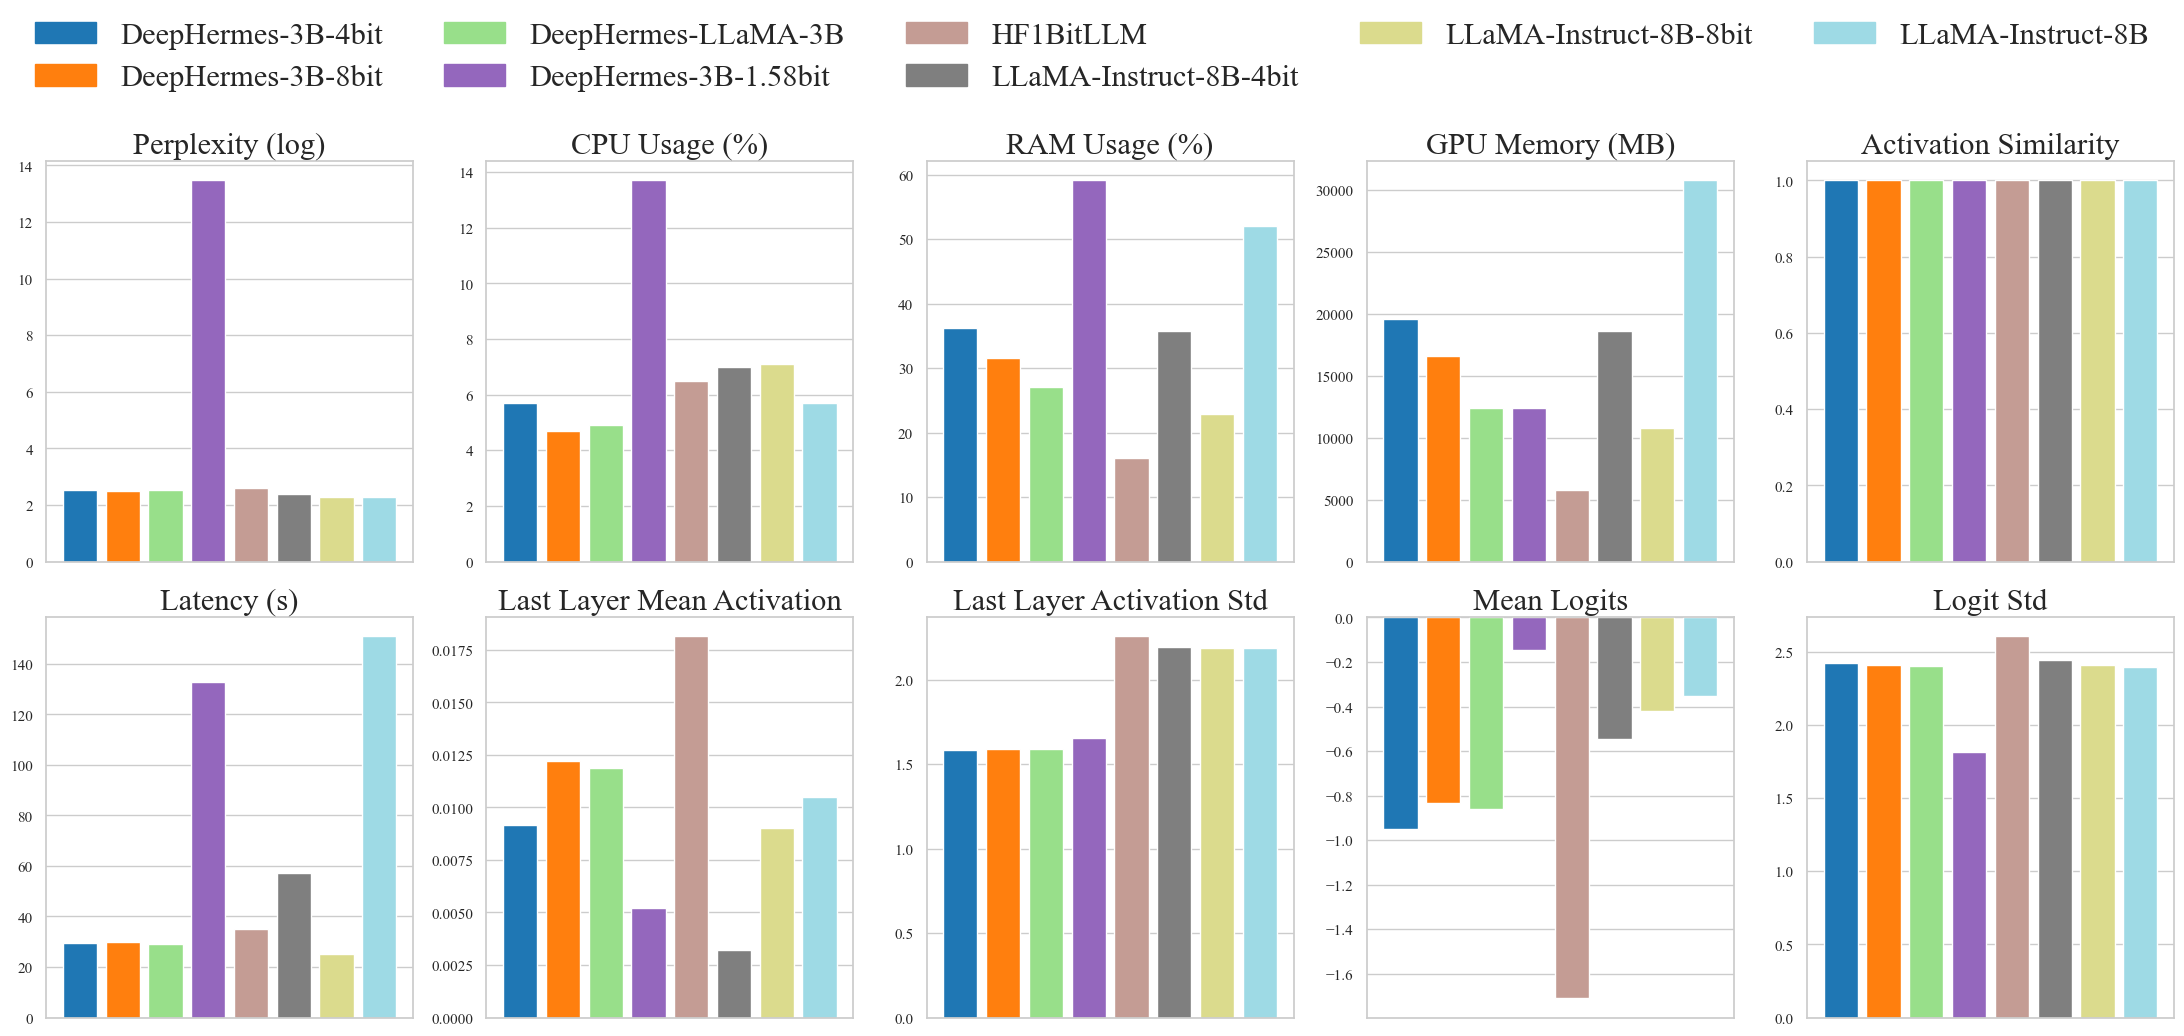

In [15]:
model_name_map = {
    'DeepHermes-LLaMA-3B': 'dh.3b-llama.fp32.json',
    'DeepHermes-3B-8bit': 'dh.3b.bnb8bit.fp32.json',
    'DeepHermes-3B-4bit': 'ldh.3b.bnb4bit.fp32.json',
    'DeepHermes-3B-1.58bit': 'dh.3b.ptsq.fp32.json',
    'LLaMA-Instruct-8B': 'llama.8b-instruct.fp32.json',
    'LLaMA-Instruct-8B-8bit': 'llama.8b-bnb8bit.fp32.json',
    'LLaMA-Instruct-8B-4bit': 'llama.8b-bnb4bit.fp32.json',
    'HF1BitLLM': 'llama.8b-1.58.fp32.json',
}

"""model_name_map_fixed = {
    key: val.replace(".json", "") for key, val in model_name_map.items()
}"""

metrics = [
    'Perplexity',
    'CPU Usage (%)',
    'RAM Usage (%)',
    'GPU Memory (MB)',
    'Activation Similarity',
    'Latency (s)',
    "Last Layer Mean Activation",
    "Last Layer Activation Std",
    "Mean Logits",
    "Logit Std",
]

plot_flat_metrics_by_model(
    df,
    metrics=metrics,
    model_col="Model",
    model_name_map=model_name_map,
    title="Flat Metrics Across Models (GSM8K)",
    log_metrics=["Perplexity"],
    save_path='GSM8K_QA'
)



In [ ]:
metrics = [
    'Perplexity',
    'CPU Usage (%)',
    'RAM Usage (%)',
    'GPU Memory (MB)',
    'Activation Similarity',
    'Latency (s)',
    "Last Layer Mean Activation",
    "Last Layer Activation Std",
    "Mean Logits",
    "Logit Std",
]

# Generate a color map
models = df['Model'].tolist()
num_models = len(models)
colors = cm.get_cmap('coolwarm', num_models)
model_colors = {model: colors(i) for i, model in enumerate(models)}

# Prepare subplot grid dynamically
n_metrics = len(metrics)
ncols = 5
nrows = int(np.ceil(n_metrics / ncols))

plt.rcParams['font.family'] = 'Times New Roman'
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax = axes[i]
    if metric in df.columns:
        for j, model in enumerate(models):
            ax.bar(model, df.loc[j, metric], color=model_colors[model])
        ax.set_title(metric, fontsize=12)
        ax.set_xticks(range(len(models)))
        ax.set_xticklabels(models, rotation=45, ha='right', fontsize=10)
        ax.grid(True)

# Hide unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Legend
##handles = [plt.Rectangle((0, 0), 1, 1, color=model_colors[model]) for model in models]
#fig.legend(handles, models, loc='upper center', ncol=min(num_models, 5))

plt.tight_layout(rect=[0, 0, 1, 0.93])
#plt.suptitle("Deep Hermes LLaMA 3B & LLaMA Instruct 8B GSM8K (n=10)", fontsize=12)
plt.suptitle("LLaMA 8B Instruct GSM8K (n=10)", fontsize=14)
plt.savefig('Outputs/Report/gsm8k_qa/llama8b_subplots.png')
plt.show()

In [ ]:
metrics = [
    'Perplexity',
    'CPU Usage (%)',
    'RAM Usage (%)',
    'GPU Memory (MB)',
    'Activation Similarity',
    'Latency (s)',
    "Last Layer Mean Activation",
    "Last Layer Activation Std",
    "Mean Logits",
    "Logit Std",
]

# Generate a color map
models = df['Model'].tolist()
num_models = len(models)
colors = cm.get_cmap('coolwarm', num_models)
model_colors = {model: colors(i) for i, model in enumerate(models)}

# Prepare subplot grid dynamically
n_metrics = len(metrics)
ncols = 5
nrows = int(np.ceil(n_metrics / ncols))

plt.rcParams['font.family'] = 'Times New Roman'
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax = axes[i]
    if metric in df.columns:
        values = df[metric].copy()

        # Normalize perplexity via log-scale
        if metric == "Perplexity":
            values = np.log1p(values)  # log1p handles 0 gracefully

        for j, model in enumerate(models):
            ax.bar(model, values[j], color=model_colors[model])
        ax.set_title(metric + (" (log)" if metric == "Perplexity" else ""), fontsize=12)
        ax.set_xticks(range(len(models)))
        ax.set_xticklabels(models, rotation=45, ha='right', fontsize=10)
        ax.grid(True)

# Hide unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Legend
##handles = [plt.Rectangle((0, 0), 1, 1, color=model_colors[model]) for model in models]
#fig.legend(handles, models, loc='upper center', ncol=min(num_models, 5))

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.suptitle("Deep Hermes 3B LLaMA & LLaMA 8B Instruct GSM8K (n=10)", fontsize=14)
plt.savefig('Outputs/Report/gsm8k_qa/llamadh3b_subplots_normalized_perplexity.png')
plt.show()

In [ ]:
# Metrics to include (excluding 'Activation Similarity')
metrics_for_corr = [
    'Perplexity',
    'CPU Usage (%)',
    'RAM Usage (%)',
    'GPU Memory (MB)',
    'Latency (s)',
    "Last Layer Mean Activation",
    "Last Layer Activation Std",
    "Mean Logits",
    "Logit Std",
]

# Compute correlation
corr_matrix = df[metrics_for_corr].corr()

# Plot
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    cmap='coolwarm', 
    fmt=".2f", 
    linewidths=0.5, 
    square=True,
    cbar_kws={"shrink": 0.75}
)
plt.title("LLaMA 8B Instruct GSM8K (n=10)", fontsize=12)
plt.tight_layout()
plt.savefig('Outputs/Report/gsm8k_qa/llama8b_corr_heatmap.png')
plt.show()

In [ ]:
torch.manual_seed(0)
original = torch.randn(512) * 0.5  # Original activations

def quantize_dequantize(tensor, scale_value):
    scale = max(scale_value, 1e-8)
    qmin, qmax = -127, 127
    tensor_int = (tensor / scale).round().clamp(qmin, qmax).to(torch.int8)
    tensor_dequant = tensor_int.float() * scale
    return tensor_int, tensor_dequant

# Quantize with different scales
_, dequant_1e2 = quantize_dequantize(original, 1e-2)
_, dequant_1e5 = quantize_dequantize(original, 1e-5)

# L2 distance
print("L2 Distance (scale=1e-2):", torch.norm(original - dequant_1e2).item())
print("L2 Distance (scale=1e-5):", torch.norm(original - dequant_1e5).item())

# Plot histograms + KDEs
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(14, 6))
sns.histplot(original.numpy(),bel='Original', kde=True, stat="count", bins=50, color='black', alpha=0.5)
sns.histplot(dequant_1e2.numpy(), label='Dequant (scale=1e-2)', kde=True, stat="count", bins=50, color='red', alpha=0.5)
sns.histplot(dequant_1e5.numpy(), label='Dequant (scale=1e-5)', kde=True, stat="count", bins=50, color='blue', alpha=0.5)

plt.title("Histogram (Count) + KDE of Quantized vs Original Activations")
plt.xlabel("Activation Value")
plt.ylabel("Count")
plt.ylim(0, 40)  
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

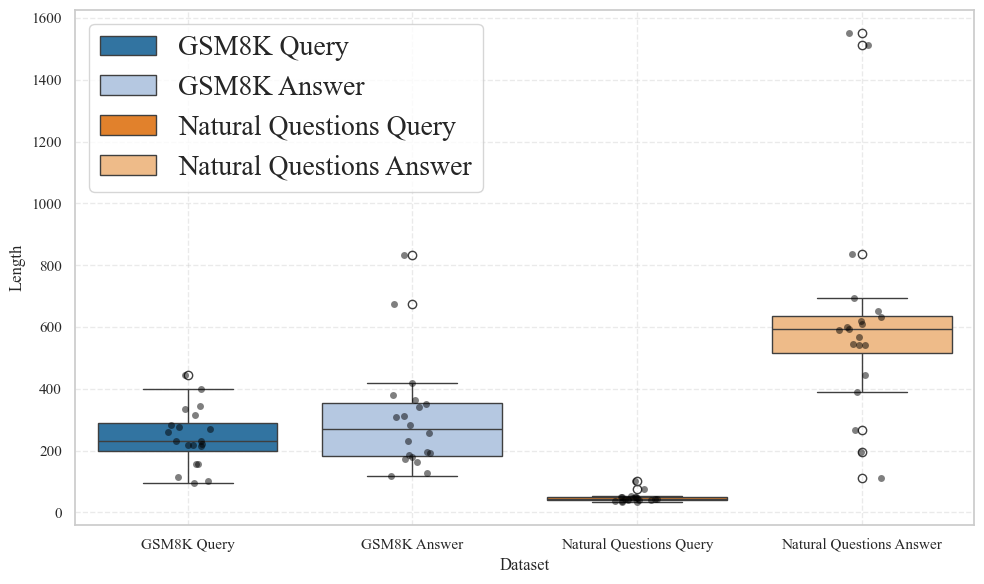

In [29]:
datasets = {
    "GSM8K Query": gsm8k_questions,  # 20 samples
    "GSM8K Answer": gsm8k_answers,
    "Natural Questions Query": nq_queries,
    "Natural Questions Answer": nq_answers,
}


length_data = []
for name, samples in datasets.items():
    for sample in samples:
        length_data.append({
            "Dataset": name,
            "Length": len(sample) 
        })


df = pd.DataFrame(length_data)

sns.set(style="whitegrid")
plt.rcParams['font.family'] = 'Times New Roman'

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="Dataset", y="Length", palette="tab20")
sns.stripplot(data=df, x="Dataset", y="Length", color="black", alpha=0.5, jitter=True)

#plt.title("Sequence Length Distribution by Dataset")
plt.legend(df['Dataset'].unique(), fontsize=20)
plt.ylabel("Length")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
#plt.savefig('datasets_lengths.jpg')
plt.show()

In [ ]:
datasets = {
    "GSM8K Query": gsm8k_questions,  # 20 samples
    "GSM8K Answer": gsm8k_answers,
    "Natural Questions Query": nq_queries,
    "Natural Questions Answer": nq_answers,
}


length_data = []
for name, samples in datasets.items():
    for sample in samples:
        length_data.append({
            "Dataset": name,
            "Length": len(sample) 
        })


df = pd.DataFrame(length_data)


fig = px.box(df, x="Dataset", y="Length", points="all", color="Dataset",
             color_discrete_sequence=px.colors.diverging.Spectral)

fig.update_layout(
    title="Sequence Length Distribution by Dataset",
    yaxis_title="Length",
    font_family="DejaVu Sans",
    showlegend=False,
    plot_bgcolor='white'
)

fig.update_yaxes(gridcolor='lightgray')
fig.show()

In [ ]:
# Compute correlation matrix
corr_matrix = df[metrics_for_corr].corr().round(2)

# Plot heatmap
fig = go.Figure(data=go.Heatmap(
    z=corr_matrix.values,
    x=corr_matrix.columns,
    y=corr_matrix.index,
    colorscale='RdBu',
    zmin=-1, zmax=1,
    colorbar=dict(title='Correlation'),
    hovertemplate='Correlation: %{z}<extra></extra>'
))

# Add text annotations
for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix)):
        fig.add_annotation(dict(
            x=corr_matrix.columns[j],
            y=corr_matrix.index[i],
            text=str(corr_matrix.values[i][j]),
            showarrow=False,
            font=dict(color="black" if abs(corr_matrix.values[i][j]) < 0.7 else "white")
        ))

fig.update_layout(
    title="LLaMA 8B Instruct GSM8K (n=10)",
    font_family="Times New Roman",
    height=700,
    width=800,
    plot_bgcolor="white"
)

fig.show()

In [ ]:
from plotly.subplots import make_subplots

# Define models and metrics
models = df['Model'].tolist()
n_models = len(models)
n_metrics = len(metrics)
ncols = 5
nrows = int(np.ceil(n_metrics / ncols))

# Create subplot grid
fig = make_subplots(rows=nrows, cols=ncols, subplot_titles=metrics)

# Assign each metric to subplot
for idx, metric in enumerate(metrics):
    row = idx // ncols + 1
    col = idx % ncols + 1

    if metric in df.columns:
        values = df[metric].copy()

        # Normalize perplexity via log-scale
        if metric == "Perplexity":
            values = np.log1p(values)

        fig.add_trace(go.Bar(
            x=models,
            y=values,
            marker_color='indianred',
            text=values.round(2),
            textposition='outside',
            name=metric
        ), row=row, col=col)

# Layout aesthetics
fig.update_layout(
    height=1000,
    width=1500,
    title_text="Deep Hermes 3B LLaMA & LLaMA 8B Instruct GSM8K (n=10)",
    showlegend=False,
    font=dict(family="Times New Roman")
)

fig.show()